https://www.youtube.com/watch?v=KYFfMymTspE

In [23]:
from keras.applications.vgg16 import VGG16
from keras.models import Sequential,Model 
from keras.layers import Dense,Dropout,Activation,Flatten,GlobalAveragePooling2D
from keras.layers import Conv2D,MaxPooling2D,ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

In [24]:
img_rows,img_cols = 128,128

VGG = VGG16(weights='imagenet',include_top=False,input_shape=(img_rows,img_cols,3))

for layer in VGG.layers:
    layer.trainable=False

def addTopModelVGG(bottom_model, num_classes):

    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(512,activation='relu')(top_model)
    top_model = Dense(256,activation='relu')(top_model)
    top_model = Dense(256,activation='relu')(top_model)
    top_model = Dense(128,activation='relu')(top_model)
    top_model = Dense(128,activation='relu')(top_model)
    top_model = Dense(num_classes,activation='softmax')(top_model)

    return top_model

num_classes = 6

FC_Head = addTopModelVGG(VGG,num_classes)

model = Model(inputs = VGG.input, outputs = FC_Head)

print(model.summary())

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0   

In [25]:
train_data_dir = 'train'
validation_data_dir = 'test'

train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=30,
                    width_shift_range=0.3,
                    height_shift_range=0.3,
                    horizontal_flip=True,
                    fill_mode='nearest'
                                   )

validation_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 32

train_generator = train_datagen.flow_from_directory(
                        train_data_dir,
                        target_size = (img_rows,img_cols),
                        batch_size = batch_size,
                        class_mode = 'categorical'
                        )

validation_generator = validation_datagen.flow_from_directory(
                            validation_data_dir,
                            target_size=(img_rows,img_cols),
                            batch_size=batch_size,
                            class_mode='categorical')

from keras.optimizers import RMSprop,Adam
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau

checkpoint = ModelCheckpoint(
                             'finger_sign_vgg_19.h5',
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(
                          monitor='val_loss',
                          min_delta=0,
                          restore_best_weights=True,
                          patience=10,
                          verbose=1)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.0001)

callbacks = [earlystop,checkpoint,learning_rate_reduction]

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=['accuracy']
              )

nb_train_samples = 1200
nb_validation_samples = 300  

epochs = 10
batch_size = 32

history = model.fit_generator(
            train_generator,
            steps_per_epoch=nb_train_samples//batch_size,
            epochs=epochs,
            callbacks=callbacks,
            validation_data=validation_generator,
            validation_steps=nb_validation_samples//batch_size)


Found 1200 images belonging to 6 classes.
Found 300 images belonging to 6 classes.
Epoch 1/10
37/37 [==============================] - 97s 3s/step - loss: 1.2600 - accuracy: 0.4897 - val_loss: 0.9516 - val_accuracy: 0.5139

Epoch 00001: val_loss improved from inf to 0.95160, saving model to finger_sign_vgg_19.h5
Epoch 2/10
37/37 [==============================] - 126s 3s/step - loss: 0.5581 - accuracy: 0.7611 - val_loss: 1.2182 - val_accuracy: 0.4888

Epoch 00002: val_loss did not improve from 0.95160
Epoch 3/10
37/37 [==============================] - 110s 3s/step - loss: 0.2649 - accuracy: 0.9058 - val_loss: 0.9595 - val_accuracy: 0.6082

Epoch 00003: val_loss did not improve from 0.95160
Epoch 4/10
37/37 [==============================] - 109s 3s/step - loss: 0.2102 - accuracy: 0.9170 - val_loss: 0.7618 - val_accuracy: 0.7649

Epoch 00004: val_loss improved from 0.95160 to 0.76177, saving model to finger_sign_vgg_19.h5
Epoch 5/10
37/37 [==============================] - 101s 3s/step

[0.48972604, 0.76113015, 0.9058219, 0.9169521, 0.9563356, 0.9623288, 0.9640411, 0.97431505, 0.9837329, 0.9982877]
[0.5138888955116272, 0.48880597949028015, 0.608208954334259, 0.7649253606796265, 0.75, 0.5335820913314819, 0.6156716346740723, 0.7201492786407471, 0.5410447716712952, 0.5858209133148193]


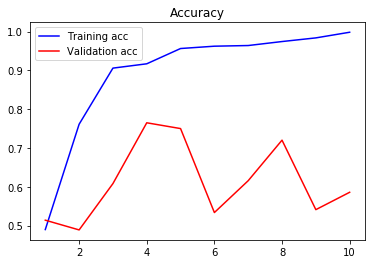

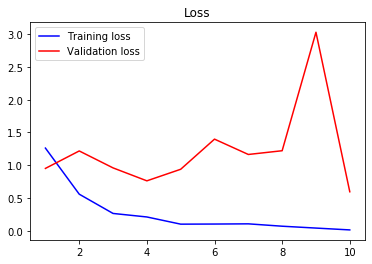

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import math

accuracy = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(1, len(accuracy) + 1)
 
plt.plot(epochs, accuracy, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Accuracy')
plt.legend()
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Loss')
plt.legend()

print(accuracy)
print(val_acc)


plt.show()
